This notebook is used to calculate scalings from a `*.pair` file

This function parses the `*.pair.gz` file and returns the `scalings`object. Make sure the python / conda environment has the required modules and the latest version of `htslib` installed.
Always sure the `chrom.sizes`file has the correct chromosomes with respect to those stored in the `*.pair`file, otherwise it will fail. 

In [3]:
import numpy as np
import pandas as pd
import pairlib
import pairlib.scalings
import pairtools
import bioframe

def computeScalings(strPairFile, strChromSizes, distRange, nBins, nChunkSize):
    chromsizes = bioframe.read_chromsizes(strChromSizes, all_names=True)
    pairs = pairtools._fileio.auto_open(strPairFile, 'r', command='bgzip -dc -@ 8')
    sc, _ = pairlib.scalings.compute_scaling(pairs, regions=None, chromsizes=chromsizes, dist_range=distRange,
                                             n_dist_bins=nBins, chunksize=nChunkSize, ignore_trans=True)
    return sc

Variables used in the current run.

In [4]:
opts_pair = ['/groups/tanaka/Projects/axolotl-genome/current/work/manuscript/rebuttal/TADs_and_CNEs/contact_probabilities/data/pair/4DNFI1TM5GVZ.pairs.gz']
opts_chromsizes = ['/groups/tanaka/github/publications/schloissnig_axolotl/data/ambMex60DD.chrom.sizes']
opts_dat = ['/groups/tanaka/Projects/axolotl-genome/current/work/manuscript/rebuttal/TADs_and_CNEs/contact_probabilities/4DNFI1TM5GVZ_new.dat']
opts_pdf = ['/groups/tanaka/Projects/axolotl-genome/current/work/manuscript/rebuttal/TADs_and_CNEs/contact_probabilities/mitotic.pdf']

opts_lims = [int(1e1), int(1e12)]
opts_nbins = [8*11]
opts_chunksize = [int(1e7)]

First, calculate the scalings. 

In [ ]:
import sys
import time
import pickle

ts = time.asctime(time.localtime())
print(f"   [{ts}] Computing the scalings in '{opts_pair[0]}'", file=sys.stderr)
sc = computeScalings(opts_pair[0], opts_chromsizes[0], opts_lims, opts_nbins[0], opts_chunksize[0])

ts = time.asctime(time.localtime())
print(f"   [{ts}] Saving the scalings into '{opts_dat[0]}'", file=sys.stderr)
with open(opts_dat[0], 'wb') as output:
    pickle.dump(sc, output, pickle.HIGHEST_PROTOCOL)

Next, load the scalings from the file and plot them. 

In [3]:
def plotData(p_curves_norm, p_derivatives, strSample, sc, chromosomes, bNorm=True):
    filtered = sc.replace(-1, np.nan).dropna()
    strand_gb = filtered.query('(chrom1 == chrom2)')
    if len(chromosomes) != 0:
        arrChr = []
        for strChr in chromosomes:
            arrChr.append(f'(chrom1 == "{strChr}")')
        strQuery = " | ".join(arrChr)
        filtered = filtered.query(strQuery)
        strSample = strSample + f' ({",".join(chromosomes)})'
    strand_gb = (filtered.query('(chrom1 != "!") & (chrom2 != "!") ').groupby(['strand1', 'strand2']))
    strand_gb = pd.concat( [ strand_gb.get_group(group) for i,group in enumerate( strand_gb.groups)] )    
    sc_agg = (strand_gb.groupby(['min_dist','max_dist']).agg({'n_pairs':'sum', 'n_bp2':'sum'}).reset_index())
    dist_bin_mids = np.sqrt(sc_agg.min_dist * sc_agg.max_dist)
    pair_frequencies = sc_agg.n_pairs / sc_agg.n_bp2
    mask = pair_frequencies > 0
    
    norm_freqs = pairlib.scalings.norm_scaling(dist_bin_mids, pair_frequencies, anchor=1e4)
    
    p_curves_norm.loglog(dist_bin_mids[mask], 
                         (norm_freqs[mask] if bNorm else pair_frequencies[mask]), 
                         label=strSample, 
                         lw=2)
    p_derivatives.semilogx(np.sqrt(dist_bin_mids.values[1:]*dist_bin_mids.values[:-1]), 
                           np.diff(np.log10(pair_frequencies.values)) / np.diff(np.log10(dist_bin_mids.values)),
                           label=strSample)

Plotting the sample: AL1 []
/users/sergej.nowoshilow/.conda/envs/cooler/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/users/sergej.nowoshilow/.conda/envs/cooler/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10
Plotting the sample: Chicken (Gibcus et al, 2018) []
/users/sergej.nowoshilow/.conda/envs/cooler/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/users/sergej.nowoshilow/.conda/envs/cooler/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10


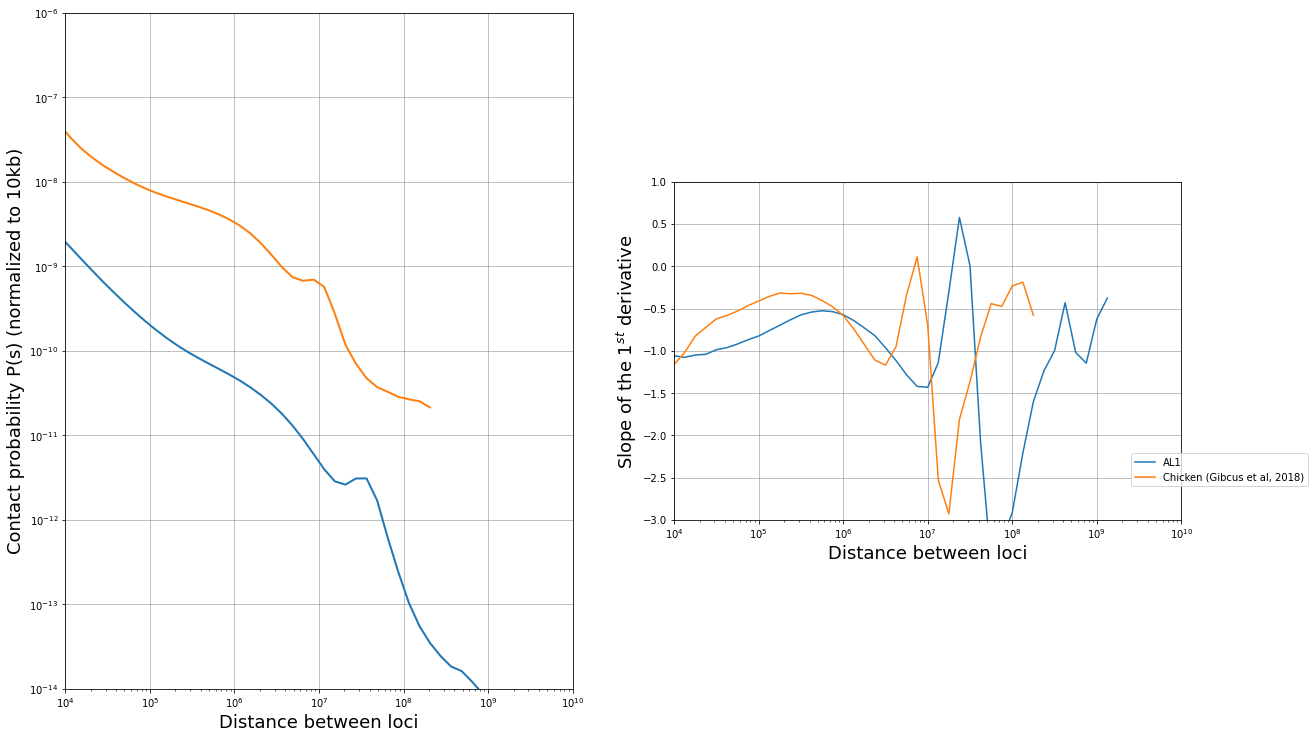

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.gridspec

import numpy as np
import pandas as pd
import pairlib
import pairlib.scalings
import pairtools
import bioframe

import sys
import time
import pickle



samples = [#['AL1-DpnII', '/groups/tanaka/Projects/axolotl-genome/AmexG_v6.0/AmexG_v6.0_DD/work/TADs/HiCUP/_amex_/AL1.DpnII.1e1-1e11.dat'],
           #['AL1-HindIII', '/groups/tanaka/Projects/axolotl-genome/AmexG_v6.0/AmexG_v6.0_DD/work/TADs/HiCUP/_amex_/AL1.HindIII.1e1-1e11.dat'],
           #['AL1-Mitotic', '/groups/tanaka/Projects/axolotl-genome/AmexG_v6.0/AmexG_v6.0_DD/work/TADs/HiCUP/_amex_/AL1.Mitotic.1e1-1e11.dat'],
           #['Human', '/groups/tanaka/Projects/axolotl-genome/AmexG_v6.0/AmexG_v6.0_DD/work/TADs/Wutz_et_al/ctrl.1e1-1e11.da'],
           #['Chicken', '/groups/tanaka/Projects/axolotl-genome/AmexG_v6.0/AmexG_v6.0_DD/work/manuscript/contact_probabilities/Chicken_30min.1e1-1e11.dat'],
           #['Chicken', '/groups/tanaka/Projects/axolotl-genome/AmexG_v6.0/AmexG_v6.0_DD/work/manuscript/rebuttal/TADs_and_CNEs/contact_probabilities/data/dat/Chicken_Pro-M_60min.4DNFI1TM5GVZ.1e1-1e11.dat'],
           #['Chicken2', '/groups/tanaka/Projects/axolotl-genome/AmexG_v6.0/AmexG_v6.0_DD/work/manuscript/rebuttal/TADs_and_CNEs/contact_probabilities/data/dat/Chicken_G2-Block.4DNFI9MMNACV.HindIII.1e1-1e11.NEW.dat']
            
           #['AL1', '/groups/tanaka/Projects/axolotl-genome/current/work/manuscript/rebuttal/TADs_and_CNEs/contact_probabilities/data/dat/AL1.HindIII.1e1-1e11.NEW.dat'],
           #['Chicken (Gibcus et al, 2018)', '/groups/tanaka/Projects/axolotl-genome/current/work/manuscript/rebuttal/TADs_and_CNEs/contact_probabilities/data/dat/Chicken_G2-Block.4DNFI9MMNACV.HindIII.1e1-1e11.NEW2.dat']
            
           ['AL1', '/groups/tanaka/Projects/axolotl-genome/current/work/manuscript/rebuttal/TADs_and_CNEs/contact_probabilities/data/dat/AL1.Mitotic.1e1-1e11.NEW.dat'],
           ['Chicken (Gibcus et al, 2018)', '/groups/tanaka/Projects/axolotl-genome/current/work/manuscript/rebuttal/TADs_and_CNEs/contact_probabilities/data/dat/Chicken_Pro-M_60min.4DNFI1TM5GVZ.NEW2.dat']
            
          ]

xmin = 1e4
xmax = 1e10


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,15))

for i, sample in enumerate(samples):
    sc = None
    chromosomes = []
    
    strSample = sample[0]
    with open(sample[1], 'rb') as data:
        sc = pickle.load(data)
        if isinstance(sc, dict):
            sc = sc['data']
        
    print(f"Plotting the sample: {strSample} {chromosomes}", file=sys.stderr)
    plotData(axs[0], axs[1], strSample, sc, chromosomes, False)
    
plt.sca(axs[0])
plt.gca().set_aspect(1.0)
plt.gca().xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=20))
plt.gca().yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=20))
plt.xlim([xmin, xmax])
plt.ylim([1e-14, 1e-6])
plt.grid(lw=0.5, color='gray')
plt.ylabel('Contact probability P(s) (normalized to 10kb)', fontsize=18)
plt.xlabel('Distance between loci', fontsize=18)

plt.sca(axs[1])
plt.gca().set_aspect(1.0)
plt.xlim([xmin, xmax])
plt.ylim([-3, 1])
plt.grid(lw=0.5, color='gray')
plt.ylabel(r'Slope of the $1^{st}$ derivative', fontsize=18)
plt.xlabel('Distance between loci', fontsize=18)

plt.legend(loc=(0.9,0.1))
plt.savefig('/groups/tanaka/Projects/axolotl-genome/current/work/manuscript/rebuttal/TADs_and_CNEs/contact_probabilities/mitotic.pdf', dpi=300)